# CS579: Lecture 10  

**Sentiment Analysis**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

*Warning: Live Twitter data is used below, some or all of which may be offensive.*

**sen·ti·ment**

1. a view of or attitude toward a situation or event; an opinion.
2. a feeling or emotion.


**sen·ti·ment &nbsp; a·nal·y·sis ** 

1. classification of documents/messages by sentiment

# Examples

![tmnt.png](tmnt.png)

![ufo](ufo.png)

![ufo-review](ufo-review.png)

![mcds](mcds.png)

![rauner](rauner.png)
![quinn](quinn.png)

## Why is this hard?


# Two Approaches

- Lexicons (word lists)

- Machine learning

# Lexicons

- List of terms with positive/negative/neutral sentiment

- E.g., AFINN: http://neuro.imm.dtu.dk/wiki/AFINN


In [150]:
# Download the AFINN lexicon, unzip, and read the latest word list in AFINN-111.txt
from collections import defaultdict
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

url = urlopen('http://www2.compute.dtu.dk/~faan/data/AFINN.zip')
zipfile = ZipFile(BytesIO(url.read()))
afinn_file = zipfile.open('AFINN/AFINN-111.txt')

afinn = dict()

for line in afinn_file:
    parts = line.strip().split()
    if len(parts) == 2:
        afinn[parts[0].decode("utf-8")] = int(parts[1])

print('read %d AFINN terms.\nE.g.: %s' % (len(afinn), str(list(afinn.items())[:10])))

read 2462 AFINN terms.
E.g.: [('vague', -2), ('bargain', 2), ('hates', -3), ('bore', -2), ('nervously', -2), ('asshole', -4), ('enterprising', 1), ('apologize', -1), ('cancelling', -1), ('belittled', -2)]


In [151]:
len(afinn)

2462

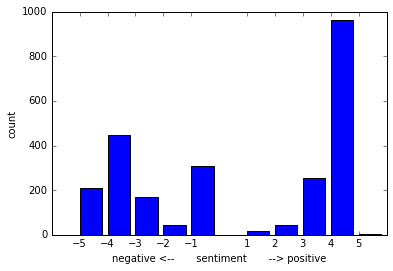

In [152]:
# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

counts = Counter(afinn.values())
vals = sorted(counts.keys())

plt.bar(vals, counts.values())
plt.xticks(vals)
plt.xlabel('negative <--       sentiment       --> positive')
plt.ylabel('count')
plt.show()

In [154]:
# How do we score a document?
def afinn_sentiment(terms, afinn):
    total = 0.
    for t in terms:
        if t in afinn:
            print('\t%s=%d' % (t, afinn[t]))
            total += afinn[t]
    return total
    
doc = "i don't know if this is a scam or if mine was broken".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	scam=-2
	broken=-1
AFINN:  -3.0


In [155]:
# What if mixed sentiment?
doc = "it has a hokey plot that is both to good and bad".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	good=3
	bad=-3
AFINN:  0.0


In [156]:
# Distinguish neutral from pos/neg.
# Return two scores per document.
def afinn_sentiment2(terms, afinn, verbose=False):
    pos = 0
    neg = 0
    for t in terms:
        if t in afinn:
            if verbose:
                print('\t%s=%d' % (t, afinn[t]))
            if afinn[t] > 0:
                pos += afinn[t]
            else:
                neg += -1 * afinn[t]
    return pos, neg

doc = "it has a hokey plot that is both to good and bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	good=3
	bad=-3
AFINN: (3, 3)


In [157]:
doc = "the plot is not bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	bad=-3
AFINN: (0, 3)


In [158]:
import configparser
from TwitterAPI import TwitterAPI

# Get some tweets about McDonald's

def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
tweets = []
for r in twitter.request('search/tweets', {'q': 'mcdonalds', 'count': 100}):
    tweets.append(r)

In [159]:
print('read %d mcdonalds tweets' % len(tweets))

read 100 mcdonalds tweets


In [169]:
# Tokenize tweets
import re

# \w = [a-zA-Z0-9_]
def tokenize(text):
    return re.sub('\W+', ' ', text.lower()).split()

tokens = [tokenize(t['text']) for t in tweets]
print('tokenized, e.g., \n%s\nto\n%s' % 
      (tweets[10]['text'], tokens[10]))
#tweets[50]['user']['name']
# tweets[50]['user']['screen_name']

tokenized, e.g., 
RT @exposinglm: 3. leigh secretly works for mcdonalds, and she got caught stealing big macs so little mix had to perform in mcdonalds to re…
to
['rt', 'exposinglm', '3', 'leigh', 'secretly', 'works', 'for', 'mcdonalds', 'and', 'she', 'got', 'caught', 'stealing', 'big', 'macs', 'so', 'little', 'mix', 'had', 'to', 'perform', 'in', 'mcdonalds', 'to', 're']


In [165]:
tokenize("Hi there how are you? Don't you ... #awesome @awesome http://www.good.com")

['hi',
 'there',
 'how',
 'are',
 'you',
 'don',
 't',
 'you',
 'awesome',
 'awesome',
 'http',
 'www',
 'good',
 'com']

In [170]:
positives = []
negatives = []
for token_list, tweet in zip(tokens, tweets):
    pos, neg = afinn_sentiment2(token_list, afinn)
    if pos > neg:
        positives.append((tweet['text'], pos, neg))
    elif neg > pos:
        negatives.append((tweet['text'], pos, neg))

In [171]:
# Print top positives:
for tweet, pos, neg in sorted(positives, key=lambda x: x[1], reverse=True):
    print(pos, neg, tweet)

5 2 RT @savangsta: how do you fall in love with someone you just met 
why do girls think it's cute to be crazy
why mcdonalds ice cream machine…
5 0 McDonalds: hailee_autumn Sounds like a good plan. Can't wait to see you!
5 1 McDonalds: AlbertoRejoice Thanks for the love! Stop by anytime.
5 0 @hailee_autumn Sounds like a good plan. Can't wait to see you!
5 1 @AlbertoRejoice Thanks for the love! Stop by anytime.
4 0 McDonalds: tayrenee23 We're so happy you feel that way, Taylor! Promise to visit again soon?
4 1 @MikeyPoole Sorry about your order! To help us improve, can you provide the location here: https://t.co/dULVemrEy1?
4 0 @tayrenee23 We're so happy you feel that way, Taylor! Promise to visit again soon?
4 1 @Hannah_Smedley Sorry about your order! To help us improve, can you provide the location here: https://t.co/9Wa9XpmAqx?
3 0 Now the kids can beg their parents for a Happy Meal at 7am.... https://t.co/BrvlMwBhjK
3 0 McDonalds: heseIegant You’re in for a treat! Celebrate the lovi

In [143]:
afinn_sentiment2(tokenize('Interested in a #job in #Redmond, WA? This could be a great fit: https://t.co/iF8xH1PuC4 #Hospitality #Hiring #CareerArc'),
                 afinn, verbose=True)

	interested=2
	great=3
	fit=1


(6, 0)

In [173]:
# Print top negatives:
for tweet, pos, neg in sorted(negatives, key=lambda x: x[2], reverse=True):
    print(pos, neg, tweet)

0 7 RT @Wtfffstephh: I fucking hate mcdonalds , I will never eat there ..
2 4 2 sweet and sour sauces but none in the bag once again @McDonalds fuck this jazz https://t.co/Hk93mM5eps
0 4 RT @Ayye_pap: AYE MA DUKES. I ASKED YOU IF WE COULD GO TO MCDONALDS, NOT IF IT WAS FOOD IN DA DAMN HOUSE‼️😡😤😢😂 #PaptingAFool https://t.co/o…
0 4 RT @Ayye_pap: AYE MA DUKES. I ASKED YOU IF WE COULD GO TO MCDONALDS, NOT IF IT WAS FOOD IN DA DAMN HOUSE‼️😡😤😢😂 #PaptingAFool https://t.co/o…
0 3 RT @vrschwrngsbot: McDonalds unterdrückt die Mächte
0 2 RT @Transfofa: TRANS-SCRIBE: Transgender Teen Fired From McDonalds Following Me... https://t.co/fjl4Mi5Jhv
0 2 RT @G6throughF5: 'F-CK WHITES': Black Woman Brags Via Twitter About Spitting In 'White Peoples Food' https://t.co/nafG0GxLDD

Boycott @McDo…
0 2 TRANS-SCRIBE: Transgender Teen Fired From McDonalds Following Me... https://t.co/fjl4Mi5Jhv
0 1 RT @LuiCalibre: @H2ODelirious @BasicallyIDoWrk @McDonalds with egg or no egg?
0 1 RT @felipeneto: Fui no @McDonalds

In [172]:
afinn_sentiment2(tokenize('@MikeyPoole Sorry about your order! To help us improve, can you provide the location here'),
                 afinn, verbose=True)

	sorry=-1
	help=2
	improve=2


(4, 1)

# Sentiment Trends?
![politico](politico.png)

What can go wrong?

<br><br><br><br>

In [175]:
# Which words contribute most to sentiment?
all_counts = Counter()
for tweet in tokens:
    all_counts.update(tweet)
sorted_tokens = sorted(all_counts.items(), key=lambda x:x[1], reverse=True)
i = 0
for token, count in sorted_tokens:
    if token in afinn:
        print('%s count=%d sentiment=%d' % (token, count, afinn[token]))
        i += 1
        if i > 10:
            break

celebrate count=8 sentiment=3
no count=6 sentiment=-1
share count=5 sentiment=1
big count=4 sentiment=1
happy count=4 sentiment=3
love count=3 sentiment=3
good count=3 sentiment=3
stop count=3 sentiment=-1
want count=3 sentiment=1
favorite count=2 sentiment=2
damn count=2 sentiment=-4


In [176]:
[t for t in tokens if 'celebrate' in t]

[['mcdonalds',
  'heseiegant',
  'you',
  're',
  'in',
  'for',
  'a',
  'treat',
  'celebrate',
  'the',
  'lovin',
  'with',
  'a',
  'bogo',
  'breakfast',
  'sandwich',
  'offer',
  'through',
  'our',
  'https',
  't',
  'co',
  'vamhwrttpo'],
 ['ashley_shultz',
  'you',
  're',
  'in',
  'for',
  'a',
  'treat',
  'celebrate',
  'the',
  'lovin',
  'with',
  'a',
  'bogo',
  'breakfast',
  'sandwich',
  'offer',
  'through',
  'our',
  'app',
  'https',
  't',
  'co',
  'ugn1q532zk'],
 ['mcdonalds',
  '123_kera',
  'we',
  'heard',
  'you',
  'celebrate',
  'any',
  'time',
  'of',
  'day',
  'with',
  'a',
  'bogo',
  'offer',
  'through',
  'our',
  'app',
  'https',
  't',
  'co',
  '1zrhxsw03c'],
 ['mcdonalds',
  'cameronjaaames',
  'you',
  're',
  'in',
  'for',
  'a',
  'treat',
  'celebrate',
  'the',
  'lovin',
  'with',
  'a',
  'bogo',
  'breakfast',
  'sandwich',
  'offer',
  'through',
  'https',
  't',
  'co',
  'vvkhzwrx5u'],
 ['mcdonalds',
  'jeohns',
  'you',
  

# Part of speech?

> *I hate McDonlads.*  
> *Hate speech is wrong.*

> *Rauner is lying.*  
> *Lying in bed with the flu.*

Noun/verb/adjective form of term may have different sentiment.

# WordNet

- A database of words and their relations
- http://wordnet.princeton.edu/
- Statistics: http://wordnet.princeton.edu/wordnet/man/wnstats.7WN.html

# WordNet

- **Synset:**
  - A list of synonyms
  - E.g. [dog](http://wordnetweb.princeton.edu/perl/webwn?s=dog&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=11000000000000000000001000000000)
- **Hypernym:**
  - Y is a Hypernym of X if every X is a kind of Y
    - **canine** is a hypernym of **dog**
- **Hyponym:**
  - Y is a Hyponym of X if every Y is a kind of X
    - **dog** is a hyponym of **canine**
    
<br><br><br>

<img src="https://upload.wikimedia.org/wikipedia/en/1/1f/Hyponymsandhypernyms.jpg">

# SentiWordNet

http://sentiwordnet.isti.cnr.it/

![senti](senti.png)

[source](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf)

In [177]:
from nltk.corpus import sentiwordnet as swn
# Depends on nltk (pip install nltk)
# See http://www.nltk.org/data.html
happy = list(swn.senti_synsets('happy', 'a'))[0]

print('happy(n): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (happy.neg_score(), happy.pos_score(), happy.obj_score()))

happy(n): negative_score=0.00 positive_score=0.88 objective_score=0.12


In [178]:
hate = list(swn.senti_synsets('hate', 'n'))[0]

print('hate(n): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(n): negative_score=0.38 positive_score=0.12 objective_score=0.50


In [149]:
hate = list(swn.senti_synsets('hate', 'v'))[0]

print('hate(v): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(v): negative_score=0.75 positive_score=0.00 objective_score=0.25


In [183]:
hate = list(swn.senti_synsets('good', 'a'))[1]
print('good(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

good(a): negative_score=0.00 positive_score=1.00 objective_score=0.00
